<h1>Bagging and Random Forests</h1>

We'll start introducing emsemble models using decision trees. The premise behind ensemble models is to use a series of weak learners and combine them in such a way that they become a strong learner. 

<h2>Bootstrapping and Bagging</h2>

There is a sampling technique called bootstrapping where you repeatedly choose a subset of data and calculate a property based on that subset. You then repeat the sampling process and average the calculations of the property together. In this way you average out the variance from your sample across these computations.

This effectively leads us to Bagging, where we train a set of predictive models and then average their predictions:
$$f_{avg}(X) = \frac{1}{B}\sum \hat{f}_i(X)$$

In most cases we train each $i$th model on a set of bootstrapped data (a subsample of the whole dataset).

For trees, our bagging algorithm would be as follows:
- create a sub-sample of the data using bootstrapping
- train a decision tree without pruning
- repeat for $i$ sub-samples
- average together the individual decision trees

Because each of the trees is grown deep, they have high variance. Averaging will reduce the variance and create a less overfit prediction.

Let's see this in practice:

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("heart.csv")
print(df.shape)
df.head()

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


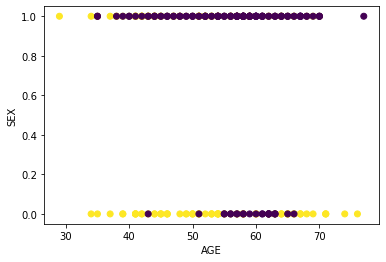

In [15]:
plt.scatter(df['age'],df['sex'],c=df['output'])
plt.xlabel("AGE")
plt.ylabel("SEX")
plt.show()

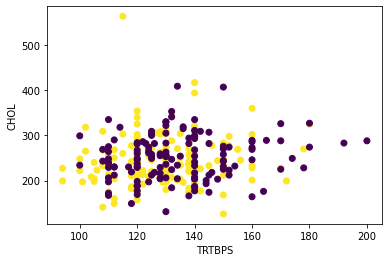

In [16]:
plt.scatter(df['trtbps'],df['chol'],c=df['output'])
plt.xlabel("TRTBPS")
plt.ylabel("CHOL")
plt.show()

From these cursory looks at the data we can probably draw linear decision boundaries the way that trees do!

Let's start with one tree:

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [18]:
y = df['output']
X = df.drop('output', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

For one tree we get the following accuracy:

In [29]:
clf = DecisionTreeClassifier(splitter='random')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7362637362637363


What happens if we train 100 trees on 100 different subsets of data?

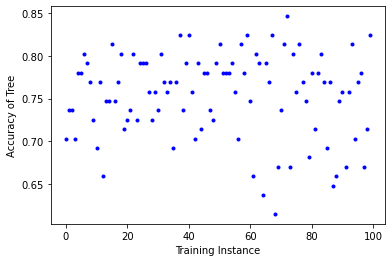

In [32]:
accuracy_scores = []
for i in range(100):
    X_train_sub, y_train_sub = resample(X_train, y_train, replace=False, n_samples=100)
    clf = DecisionTreeClassifier(max_depth=3)
    clf.fit(X_train_sub, y_train_sub)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
plt.plot(range(100), accuracy_scores, 'b.')
plt.xlabel('Training Instance')
plt.ylabel('Accuracy of Tree')
plt.show()

In [33]:
final_list = []
for j in [1,5,10,20,50,100,250,500,750,1000,2500,5000,7500]:
    pred_list = []
    for i in range(j):
        X_train_sub, y_train_sub = resample(X_train, y_train, replace=False, n_samples=100)
        clf = DecisionTreeClassifier()
        clf.fit(X_train_sub, y_train_sub)
        y_pred = clf.predict(X_test)
        pred_list.append(y_pred)
    df_preds = pd.DataFrame(pred_list)
    y_bagged = round(df_preds.mean(axis=0)).values
    final_list.append([j, accuracy_score(y_test, y_bagged)])

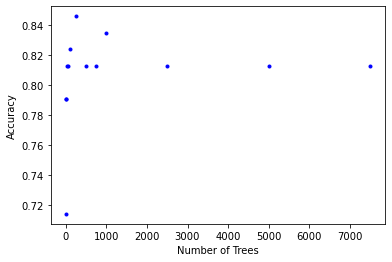

In [34]:
import numpy as np
final_array = np.asarray(final_list)
plt.plot(final_array[:,0], final_array[:,1], 'b.')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()

We see that the variance is reduced as we increase the number of trees that we average over!

<h3>Out Of Bag Error Estimation</h3>

There's a neat way to estimate the error of a bagged model without having to do cross-validation. One can show (but we won't do it here) that on average a bagged tree only uses 2/3 of the observations in its contstruction. The remaining 1/3 of the data are called "out of bag observations". For each tree that didn't use observation $i$ we can make a prediction and average them together. For sufficiently many trees this is a good approximation of the cross-validation error you would obtain. Most packages will have a built in way to find these out of bag observations and estimate the out of bag error.

<h2>Random Forests</h2>

The random forest algorithm uses bagging in a unique way in order to pick the best features to use in order to construct a tree. In addition to bootstrapping the data, we will also choose a subset of the features to construct each tree.

The algorithm is as follows:
- construct a decision tree using $m$ random features to make the splits
- bag a number of these trees using a new random sample of data and a new random sample of features
- the final prediction is the average of all the trees

We can extend our code now to use a subset of features:

In [35]:
rf_list = []
for j in [1,5,10,20,50,100,250,500,750,1000,2500,5000,7500]:
    pred_list = []
    for i in range(j):
        X_train_sub, y_train_sub = resample(X_train, y_train, replace=False, n_samples=100)
        X_train_sub = X_train_sub.sample(n=4, axis='columns')
        X_cols = X_train_sub.columns
        clf = DecisionTreeClassifier()
        clf.fit(X_train_sub, y_train_sub)
        y_pred = clf.predict(X_test[X_cols])
        pred_list.append(y_pred)
    df_preds = pd.DataFrame(pred_list)
    y_bagged = round(df_preds.mean(axis=0)).values
    rf_list.append([j, accuracy_score(y_test, y_bagged)])

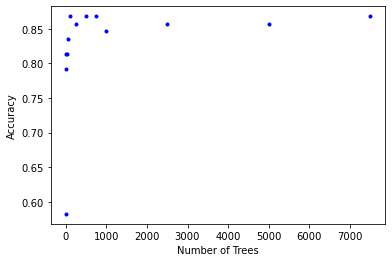

In [12]:
rf_array = np.asarray(rf_list)
plt.plot(rf_array[:,0], rf_array[:,1], 'b.')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()

Why does this seem to work?

If you remember back to how we construct our trees, we take a greedy approach. This means that we will always look for the feature to split on that maximizes the information gain at the top of the tree. By limiting the set of features that can be used we force our algorithm to try "less optimal" trees. This means our trees will be less correlated with each other, reduce variance, and provide more reliable predictions.